## Introduction

#### Author - Chaman Gupta
#### Last Updated - 02/16/2023

Install the following libraries by copying each line to your command prompt/terminal:

***
`pip install traitlets`

`pip install peakutils`

`pip install ipywidgets`

`pip install tkinter`
***

### Import Libraries

In [1]:

# Import libraries
import os
import traitlets
from ipywidgets import *
from IPython.display import display, Javascript, clear_output

import numpy as np
import pandas as pd
import matplotlib
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline                    # Safe smooth interpolation
from scipy.signal import find_peaks
from scipy.signal import medfilt
from scipy import signal
from pybaselines import Baseline, utils
from scipy.integrate import simpson, trapz

from tkinter import Tk, filedialog

import peakutils
from peakutils.plot import plot as pplot

from tqdm import tqdm
from __future__ import print_function

### Set graphing properties

In [2]:
## Set graphing properties

matplotlib.rcParams['font.sans-serif'] = ['Arial'] # Helvetica
plt.rcParams["figure.figsize"] = (15,7)

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Define all functions

In [3]:
## Defining all functions

# DO NOT CHANGE anything - except the locaiton of your lamp data file ( it is in the i_corr function)

class SelectFilesButton(widgets.Button):
    """A file widget that leverages tkinter.filedialog."""

    def __init__(self, *args, **kwargs):
        """Initialize the SelectFilesButton class."""
        super(SelectFilesButton, self).__init__(*args, **kwargs)
        # Add the selected_files trait
        self.add_traits(files=traitlets.traitlets.List())
        # Create the button.
        self.description = "Select File"
        self.icon = "square-o"
        self.style.button_color = "orange"
        # Set on click behavior.
        self.on_click(self.select_files)

    @staticmethod
    def select_files(b):
        """Generate instance of tkinter.filedialog.
        Parameters
        ----------
        b : obj:
            An instance of ipywidgets.widgets.Button
        """
        # Create Tk root
        root = Tk()
        # Hide the main window
        root.withdraw()
        # Raise the root to the top of all windows.
        root.call('wm', 'attributes', '.', '-topmost', True)
        # List of selected fileswill be set to b.value
        b.files = filedialog.askopenfilename(multiple=True)
        f = b.files
        '''
        for i in range(0,len(f)):
            print(i,f[i],end="\n")   # load preview cut process plot
        '''
        b.description = "Files Selected"
        b.icon = "check-square-o"
        b.style.button_color = "lightgreen"

def get_data_txt(f,i):

    data = pd.read_csv(f[i], sep=' ',engine='python', names=['col_a_data','col_b_data'])
    x = data['col_a_data'].to_numpy()
    y = data['col_b_data'].to_numpy()
    
    return x,y

def get_data(f,i):

    data = pd.read_csv(f[i], sep=',',engine='python', names=['col_a_data','col_b_data'])
    x = data['col_a_data'].to_numpy()
    y = data['col_b_data'].to_numpy()
    
    return x,y

def get_data_MAF_RW(f,i):
    
    data = pd.read_csv(f[i], sep='\t', skiprows=1, names=['col_a_data','col_b_data'])
    
    x = data['col_a_data'].to_numpy()
    y = data['col_b_data'].to_numpy()
    
    return x,y

def data_cleaning(data,erp):
    
    # Code to remove cosmic rays
    #erp=100 # Set percentage error limit
    err=erp/100

    Ndatapts = len(data)
    ydata = data

    for i in range(0,Ndatapts): # This loop removes hot regions one pixel wide
        if i>0 and i<Ndatapts-1:
            if ydata[i]>(1+err)*ydata[i+1] and ydata[i]>(1+err)*ydata[i-1]:
                #print('Entered the loop 1')
                ydata[i]=(ydata[i-1]+ydata[i+1])/2

    for i in range(0,Ndatapts): # This loop removes hot regions up to 3 pixels wide
        if i>1 and i<Ndatapts-2 and ydata[i]>(1+err)*ydata[i+2] and ydata[i]>(1+err)*ydata[i-2]:
            #print('Entered the loop 3')
            ydata[i], ydata[i-1], ydata[i+1] = (ydata[i-2]+ydata[i+2])/2, (ydata[i]+ydata[i-2])/2, (ydata[i+2]+ydata[i])/2

    for i in range(0,Ndatapts): # This loop removes hot regions up to 5 pixels wide
        if i>4 and i<Ndatapts-5 and ydata[i]>(1+err)*ydata[i+5] and ydata[i]>(1+err)*ydata[i-5]:
            #print('Entered the loop 3')
            ydata[i], ydata[i-1], ydata[i-2], ydata[i-3], ydata[i-4], ydata[i+1], ydata[i+2], ydata[i+3], ydata[i+4] = (ydata[i-5]+ydata[i+5])/2, (ydata[i]+ydata[i-2])/2, (ydata[i-1]+ydata[i-3])/2, (ydata[i-2]+ydata[i-4])/2, (ydata[i-3]+ydata[i-5])/2, (ydata[i+2]+ydata[i])/2, (ydata[i+3]+ydata[i+1])/2, (ydata[i+4]+ydata[i+2])/2, (ydata[i+5]+ydata[i+3])/2

    for i in range(0,Ndatapts): # This loop removes dead regions one pixel wide
        if i>0 and i<Ndatapts-1 and ydata[i]<(1-err)*ydata[i+1] and ydata[i]<(1-err)*ydata[i-1]:
            #print('Entered the loop 4')
            ydata[i]=(ydata[i-1]+ydata[i+1])/2

    for i in range(0,Ndatapts): # This loop removes dead regions up to 3 pixels wide
        if i>1 and i<Ndatapts-2 and ydata[i]<(1-err)*ydata[i+2] and ydata[i]<(1-err)*ydata[i-2]:
            #print('Entered the loop 5')
            ydata[i], ydata[i-1], ydata[i+1] =(ydata[i-2]+ydata[i+2])/2, (ydata[i]+ydata[i-2])/2, (ydata[i+2]+ydata[i])/2
            
    return ydata

def subtract_bsl(x,y,hf):
    
    baseline_fitter = Baseline(x, check_finite=False)
    base = baseline_fitter.mor(y, half_window=hf)[0]
    
    return base

def filter_savgol(data,k_size,p_order):
    
    data[np.isnan(data)] = 0
    
    sav_filt_data=signal.savgol_filter(data,k_size,p_order)
    
    return sav_filt_data

def filter_median(data,k_size):
    
    filt_data = medfilt(data,kernel_size=k_size)
    
    return filt_data

def i_corr(flamp,f,i):
    start = 0
    end = -1

    head_i, tail_i = os.path.split(f[i])
    
    ## Important note to change the location of this .txt file below to where it is in your computer.
    calibstd = np.loadtxt(r"G:\Shared drives\Pauzauskie Team Drive\CG\Scripts\030410638_HL-2000-CAL_2014-01-15-14-09_VISEXT1EXT2_FIB.txt")
    xcalib = calibstd[:,0]
    ycalib = calibstd[:,1]

    x,y = get_data(f,i)

    HglampFunc = CubicSpline(xcalib,ycalib)
    hglampI = HglampFunc(x) # Create interpolation of true lamp spectrum
    
    if flamp[0][-4:] == '.txt':
        hglampdata_x, hglampdata_y = get_data_txt(flamp,0) # Split true lamp spectra into x and y
    else:
        hglampdata_x, hglampdata_y = get_data(flamp,0) # Split true lamp spectra into x and y
    
    ICF = hglampI/(hglampdata_y) # Creates ratio of true lamp spectra to real lamp data, ICF = Intensity Correction Factor

    ynew = (y)*ICF # multiplies real data by intensity correction factor

    ynew = np.nan_to_num(ynew,nan=0,posinf=0,neginf=0)
    datamatrix = np.column_stack((x,ynew)) # Compiles corrected data into a new matrix
    savename = f[i][:-4]+"_calib.txt" # Create filename for new data
    
    head_c, tail_c = os.path.split(savename)
    
    np.savetxt(savename, datamatrix) # Save new data

    return x,y,ynew

def slicing_func(x,y,yi,start_x,end_x):
    start = np.argmin(abs(x-start_x))
    end = np.argmin(abs(x-end_x))
    #print(start,end)
    x_cut = x[start:end]
    y_cut = y[start:end]
    yi_cut = yi[start:end]
    
    return x_cut, y_cut, yi_cut, start, end

def _3Lorentzian(x, amp1, cen1, wid1, amp2,cen2,wid2, amp3,cen3,wid3):
    return (amp1*wid1**2/((x-cen1)**2+wid1**2)) +\
            (amp2*wid2**2/((x-cen2)**2+wid2**2)) +\
                (amp3*wid3**2/((x-cen3)**2+wid3**2))
 
def mean_f_wvl(x,y,meanf_method):
    
    lambda_f = None
    
    if meanf_method == 'area':
        lambda_f = np.sum(x*y**2) /np.sum(y**2)
    elif meanf_method == 'sum':
        lambda_f = np.sum(x*y)/np.sum(x)
    elif meanf_method == 'integrate':
        lambda_f = simpson(x*y,x)/simpson(y,x)
    elif meanf_method == 'energy':
        x = 1240/x
        y = (1240/(x**2))*y
        e_f = simpson(x*y,x)/simpson(y,x)
        lambda_f = 1240/e_f
        
    return lambda_f
                
def _1Lorentzian(x, amp1, cen1, wid1):
    return (amp1*wid1**2/((x-cen1)**2+wid1**2))

### Clean Intensity Correction files

In [4]:
def i_corr_cleaning(iFiles,do_baseline_subtraction,do_median_filtering,do_data_cleaning,do_savgol_filtering,do_conversion,do_normalize,do_peak_finding,p_order,k_size,erp,k_size_savgol,p_order_savgol):
    idata = iFiles.files

    # file_data_df = pd.DataFrame() # Dataframe to store peak values or any other information

    x_label = 'Wavelength (nm)' # Set a default label for x-axis to Wavelength.

    # mp = [] # Array to store peak values or other information
    fig1, ax1 = plt.subplots(1, 1) # Put this outside loop if you want only one plot with all cruves. Keep it inside if you want separate plots

    for i in tqdm(range(len(idata))):
        
        idata_name = idata[i]
        print(idata_name)

        head_i, tail_i = os.path.split(idata[i])

        ixdata, iydata = get_data(idata, i)

        if do_median_filtering == 'y':
            filt_idata = filter_median(iydata, k_size)
        else:
            filt_idata = iydata

        if do_baseline_subtraction == 'y':
            base = subtract_bsl(filt_idata, p_order)
        else:
            base = 0

        bsl_subt_idata = filt_idata - base

        if do_data_cleaning == 'y':
            cleaned_idata = data_cleaning(bsl_subt_idata, erp)
        else:
            cleaned_idata = bsl_subt_idata

        if do_savgol_filtering == 'y':
            savgol_filt_idata = filter_savgol(cleaned_idata, k_size_savgol,p_order_savgol)
        else:
            savgol_filt_idata = cleaned_idata

        ixval, iyval = ixdata, savgol_filt_idata

        iyval_new = np.nan_to_num(iyval,nan=0,posinf=0,neginf=0)
        i_datamatrix = np.column_stack((ixval,iyval_new)) # Compiles corrected data into a new matrix
        i_save = idata_name[:-4]+"_cleaned.txt" # Create filename for new data
        print(i_save)
        head_is, tail_is = os.path.split(i_save)
        np.savetxt(i_save, i_datamatrix) # Save new data
        
        ax1.plot(ixval, iyval_new,label=tail_is) # Code line to plot the curves
        #ax1.annotate("2.28 eV (543 nm)", xy=(2.28,900), xytext=(1.70, 600), color='k', arrowprops=dict(arrowstyle="-|>",connectionstyle="arc3"))
    # ax1.set_title("Intensity Correction files")
    ax1.set_xlabel(x_label)
    ax1.set_ylabel('Intensity (counts)')

    # ax1.set_xlim(3000,4000)
    # ax1.set_ylim(1.5e-5,3.5e-5)

    # ax1.legend(bbox_to_anchor=(0.8, 0.8), loc='center', title="File Name")

    ax1.grid(color = 'green', which='both', linestyle = '-.', linewidth = 0.5, alpha=0.4)
        
    plt.show()
    # plt.savefig(head_i + 'H3 Diamond - 445nm excitation - data in energy.png')

In [5]:
do_lamp_cleaning = 'n' # y or n

if do_lamp_cleaning == 'y':
    print("\nSelect lamp files for cleaning and analysis \n(optional; if none is chosen, default intensity correction factor will be used): ")
    selectiCorrFiles = SelectFilesButton()
    display(selectiCorrFiles)
else:
    pass


In [6]:
## Variables
do_baseline_subtraction = 'n' # 'y', 'n'
do_median_filtering = 'n' # 'y', 'n'
do_data_cleaning = 'n' # 'y', 'n'
do_savgol_filtering = 'n' # 'y', 'n'
do_conversion = 'n' # 'raman', 'energy', 'n'
do_normalize = 'n' # 'relative' scale', 'area', 'n'
do_peak_finding = 'n' # 'y', 'n'

c_vac = 2.99*10**8 # speed of light in vacuum m/sec
laser_source = 532 # Excitation source in nm 



p_order = 5 # Polynomial order for baseline subtraction
k_size = 7 # Kernel size for Median Filtering
erp = -10
k_size_savgol = 11
p_order_savgol = 1

In [7]:
if do_lamp_cleaning == 'y':
    i_corr_cleaning(selectiCorrFiles,do_baseline_subtraction,do_median_filtering,do_data_cleaning,do_savgol_filtering,do_conversion,do_normalize,do_peak_finding,p_order,k_size,erp,k_size_savgol,p_order_savgol)
else:
    pass

### Manual Intensity Correction

In [8]:
print("Select data files you want to analyze: ")
selectFiles = SelectFilesButton()
display(selectFiles)

do_intensity_correction = 'n'

if do_intensity_correction == 'y':
    print("\nSelect tungsten halogen (Blue Ocean optics HL2000) lamp spectrum for intensity correction \n(optional; if none is chosen, default intensity correction factor will be used): ")
    selectHalLamp = SelectFilesButton()
    display(selectHalLamp)
else:
    pass

Select data files you want to analyze: 


SelectFilesButton(description='Select File', icon='square-o', style=ButtonStyle(button_color='orange'))

## Main Data Processing and Plotting

In [9]:
## Variables
is_MAF_RW_file = 'n'  # 'y', 'n'
is_fitted_data_file = 'n' # 'y', 'n'
do_baseline_subtraction = 'n' # 'y', 'n'
do_median_filtering = 'n' # 'y', 'n'
do_data_cleaning = 'n' # 'y', 'n'
do_savgol_filtering = 'n' # 'y', 'n'
do_conversion = 'n' # 'raman', 'energy', 'n'
do_normalize = 'n' # 'relative' scale', 'area', 'n'
do_peak_finding = 'n' # 'y', 'n'
do_slicing = 'n'
do_mfv_calc = 'n'

c_vac = 2.99*10**8 # speed of light in vacuum m/sec
laser_source = 532.109 # Excitation source in nm 

meanf_method = 'energy'

hf = 20
p_order = 5 # Polynomial order for baseline subtraction
k_size = 7 # Kernel size for Median Filtering
erp = -5
k_size_savgol = 3
p_order_savgol = 1

start_x = 830
end_x = 1020
def ram2nm(x):
    return 10**7/(10**7/laser_source - x)

def nm2ram(x):
    return 10**7*(1/laser_source - 1/x)

100%|██████████| 70/70 [00:01<00:00, 63.91it/s]


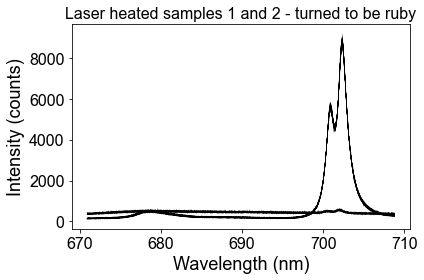

In [11]:
fdata = selectFiles.files

# file_data_df = pd.DataFrame() # Dataframe to store peak values or any other information

if do_intensity_correction == 'y':
    flamp = selectHalLamp.files
else:
    pass

x_label = 'Wavelength (nm)' # Set a default label for x-axis to Wavelength.

laser_Pow = []

meanf_df = pd.DataFrame(columns=('File Name','Power', 'Mean Wvl'))

# Put this outside loop if you want only one plot with all cruves. Keep it inside if you want separate plots

fig1 = plt.figure()


if do_mfv_calc == 'y':
    ax1 = fig1.add_subplot(121)
    ax2 = fig1.add_subplot(122)
else:
    ax1 = fig1.add_subplot(111)
        
for i in tqdm(range(0, len(fdata))):
    
    # fig = plt.figure()
    # ax1 = fig.add_subplot(121) # Put this outside loop if you want only one plot with all cruves. Keep it inside if you want separate plots

    head_i, tail_i = os.path.split(fdata[i])
    #print(tail_i)

    if is_MAF_RW_file == 'y':
        x_data, y_data = get_data_MAF_RW(fdata, i)
        x_label = 'Raman shift(cm$^{-1}$)'

    if is_fitted_data_file == 'y':
        data_df = pd.read_csv(fdata[i], sep=None, engine='python', header=None)
        col_len = len(data_df.columns)
        row_len = len(data_df.index)

        x_data = data_df[0].to_numpy()
        y_data = data_df[1].to_numpy()
        #start = np.argmin(abs(x_data-350))
        #end = np.argmin(abs(x_data-420))
        #x_data = x_data[start:end]
        
        #y_data = np.zeros(shape=(len(x_data),col_len-1))
        
        #for k in range(col_len-1):
        #    y_data[:,k] = data_df.iloc[:,k+1].values
        
        #print(y_data)
    else:
        if fdata[i][-4:] == '.txt':
            #print('enetered loop')
            x_data, y_data = get_data_txt(fdata, i)
        else:
            x_data, y_data = get_data(fdata, i)
    
    if do_intensity_correction == 'y':
        x_data, y_data, intens_data = i_corr(flamp, fdata, i)
    else:
        intens_data = y_data
    #print(x_data,y_data)
    if do_slicing == 'y':
        x_data, y_data, intens_data, start, end = slicing_func(x_data,y_data,intens_data,start_x,end_x)

    if do_normalize == 'relative':
        norm_intens_data = (intens_data - np.min(intens_data)) / (np.max(intens_data) - np.min(intens_data))
    elif do_normalize == 'scale':
        norm_intens_data = intens_data / np.max(intens_data)
    elif do_normalize == 'area':
        norm_intens_data = intens_data/np.trapz(intens_data,x_data)
    else:
        norm_intens_data = intens_data

    if do_median_filtering == 'y':
        filt_data = filter_median(norm_intens_data, k_size)
    else:
        filt_data = norm_intens_data

    if do_baseline_subtraction == 'y':
        base = subtract_bsl(x_data,filt_data,hf)
    else:
        base = 0

    bsl_subt_data = filt_data - base

    if do_data_cleaning == 'y':
        cleaned_data = data_cleaning(bsl_subt_data, erp)
    else:
        cleaned_data = bsl_subt_data

    if do_savgol_filtering == 'y':
        savgol_filt_data = filter_savgol(cleaned_data, k_size_savgol,p_order_savgol)
    else:
        savgol_filt_data = cleaned_data

    if do_conversion == 'raman':
        x_val = nm2ram(x_data)
        x_label = 'Raman shift(cm$^{-1}$)'
        y_val = savgol_filt_data*x_data/10**7
    elif do_conversion == 'energy':
        x_val = 1240 / x_data
        x_label = 'Energy(eV)'
        y_val = (1240/(x_val**2))*savgol_filt_data
    else:
        x_val = x_data
        y_val = savgol_filt_data
    
    if do_mfv_calc == 'y':
        mean_f = mean_f_wvl(x_val,y_val,meanf_method)
        
        string_start = '1020'
        string_end = 'et'
        string_to_search = 'Pow_'
        string_to_end = 'mW'
        
        power_start = tail_i.find(string_to_search,tail_i.find(string_start),tail_i.find(string_end)) + 4
        power_end = tail_i.find(string_to_end,tail_i.find(string_start),tail_i.find(string_end))
        power_val = tail_i[power_start:power_end]
        if float(power_val) not in laser_Pow:
            laser_Pow.append(float(power_val))
        
        meanf_df.loc[i] =  [tail_i,float(power_val),float(mean_f)]
        #ax2.scatter(power_val,mean_f,color='k')
    
    ### Peak Finding
    
    # Plotting starts below. Change the code if you want to change how the plotting happens.
    
    if do_peak_finding == 'y':
        w_size = 10
        p_prom = 2
        thresh = 2

        # mp = np.append(mp,press_find(thresh,x_val,y_val,w_size,p_prom))

        peak_x = x_val[find_peaks(y_val,width=w_size,prominence=p_prom)[0]]
        peak_y = savgol_filt_data[find_peaks(y_val,width=w_size,prominence=p_prom)[0]]

        if all(peak_y>thresh)==True:
            #print(tail_i)
            #print(peak_x, peak_y)
            ax1.scatter(peak_x, peak_y,marker='D',color='k')
        #file_data_df_i = pd.DataFrame([[tail_i, np.min(x_val),np.max(x_val)]])
        #file_data_df = file_data_df.append(file_data_df_i,ignore_index=True)
    else:
        pass

    if is_fitted_data_file == 'y':
        
        #The 'lab' is a list to store the labels for locations of peaks. Add or remove based on how many peaks you have in your fitted data file from Fityk.
        
        color_lab = []
        power_lab = []
        lab = []
        
        ax1.scatter(x_data, y_data[:,0]/np.max(y_data[:,0]), marker='o', s=4,alpha=0.8,color='r')
        
        for j in range(1,col_len-2):
            
            #Plot wihtout lables
            ax1.plot(x_data, y_data[:,j]/np.max(y_data[:,0]), lw=0.8,color='k')
            
            #Plot with labels
            # ax1.plot(x_data, y_data[:,j]/np.max(y_data[:,0]), lw=0.8,color='k', label=str(lab[j-1]) + " nm -- " + str.format('{0:.1f}',nm2ram(lab[j-1])) + " cm$^{-1}$")
            
            #Add vertical lines
            #ax1.vlines(lab[j-1], ymin=0, ymax = 1.04, linestyles='dashed', color='k', alpha=0.6)
            #max_y_ht = np.max(y_data) + 100
            
            #Add text annotation
            #ax1.annotate(str(lab[i-2]), (lab[i-2], 250), color='k', rotation=90, size)
            #ax1.text(lab[j]+.8, 1.1, str(lab[j]), rotation=90, fontsize = 13)
            
        ax1.plot(x_data, y_data[:,-1]/np.max(y_data[:,0]), lw=3,color='b')
    else:
        
        y_per = y_val
                
        ax1.plot(x_val, y_per,label=tail_i,color='k',lw=0.2, ls='-') # Code line to plot the curves
        
    # General plot properties are set below
        
    ax1.set_title('Laser heated samples 1 and 2 - turned to be ruby')
    ax1.set_xlabel(x_label)
    ax1.set_ylabel('Intensity (counts)')
    #ax1.set_xlim()
    #ax1.set_ylim()
    
    #ax1.set_yticks([])
    #ax1.tick_params(axis='y',which='both',left='off',labelleft='off')

    #ax1.legend(bbox_to_anchor=(1, 1),title='Peak Positions')

    # Add a secondary x-axis
    #secax = ax1.secondary_xaxis('top', functions=(nm2ram, ram2nm))
    #secax.set_xlabel('Raman shift (cm$^{-1}$)')

if do_mfv_calc == 'y':
    for laser_power in laser_Pow:
        print(laser_power)
        #power_str = str(laser_power)
        df2 = meanf_df.iloc[list(meanf_df["Power"]==laser_power)]
        meanf_val = df2['Mean Wvl'].mean()
        sme_val = df2['Mean Wvl'].std()/df2['Mean Wvl'].count()
        ax2.errorbar(laser_power,meanf_val,yerr=sme_val, marker='s',color='k',markersize=10,capsize=6,barsabove=True,ecolor='k',elinewidth=2,capthick=1)
        
    ax2.set_title('Put your title here')
    ax2.set_xlabel('1020 nm laser power')
    ax2.set_ylabel('Mean f wavelength')
    #ax2.set_xlim()
    #ax2.set_ylim()
    
    #ax2.set_yticks([])
    #ax2.tick_params(axis='y',which='both',left='off',labelleft='off')

    #ax2.legend(bbox_to_anchor=(1, 1),title='Peak Positions')

#print(meanf_df)
fig1.tight_layout()
plt.show()
#plt.savefig(os.path.join(head_i,'PL_plot-09202022.jpg'))